In [69]:
import pandas as pd
v1=pd.read_csv('tess_v1.dat',sep=',',header=None)
times,fluxes,sigmas=v1[0].values,v1[1].values,v1[2].values

In [70]:
import phoebe,ellc
from phoebe import u # units

logger = phoebe.logger('error')

In [71]:
b = phoebe.default_binary()
b.add_constraint('semidetached', 'secondary')
b.add_constraint('whitedwarf', 'primary')

<ParameterSet: 1 parameters>

In [72]:
b.add_dataset('lc', compute_phases=phoebe.linspace(0,1,201),
              times=times, fluxes=fluxes, sigmas=sigmas, dataset='lc01', 
              passband='TESS:T', overwrite=True)

<ParameterSet: 78 parameters | contexts: compute, dataset, constraint, figure>

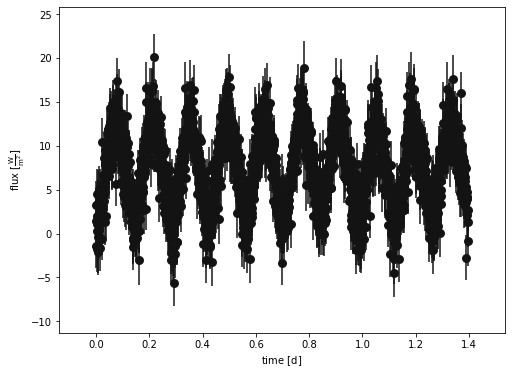

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [73]:
b.plot(show=True)

In [74]:
b.set_value('incl', component='binary', value=60*u.deg)
b.set_value('period', component='binary', value=0.139613*u.d)
b.set_value('teff', component='primary', value=90000*u.K)
b.set_value('teff', component='secondary', value=3000*u.K)
b.flip_constraint('mass@primary', solve_for='sma@binary')
b.set_value('mass', component='primary', value=1.13*u.solMass)
b.flip_constraint('mass@secondary', solve_for='q')
b.set_value('mass', component='secondary', value=0.2*u.solMass)
b.set_value('t0_supconj', component='binary', value=0.14131172)

In [75]:
b['gravb_bol@primary'] = 0
b['irrad_frac_refl_bol@primary']=0

b.set_value_all('atm', component='primary', value='blackbody')
b.set_value_all('ld_mode', component='primary', value='manual')
b.set_value_all('ld_func', component='primary', value='quadratic')
b.set_value_all('ld_coeffs', component='primary', dataset='lc01', value=[0.1225,0.3086])
b.set_value_all('ld_mode_bol@primary','manual')
b.set_value_all('ld_func_bol@primary','quadratic')
b.set_value_all('ld_coeffs_bol', component='primary', value=[0.1421,0.3693])
b.set_value_all('atm', component='secondary', value='phoenix')
b.set_value_all('ld_mode', component='secondary', value='lookup')

b.set_value_all('distortion_method@primary', value='sphere')
b.set_value_all('ntriangles@secondary', value=25000)

b.set_value_all('pblum_mode', 'dataset-scaled') #scale to the flux-levels of the obs.

In [76]:
b.run_compute(compute='phoebe01', model='after_nm_phoebe')

<ParameterSet: 4 parameters | qualifiers: fluxes, times, comments, flux_scale>

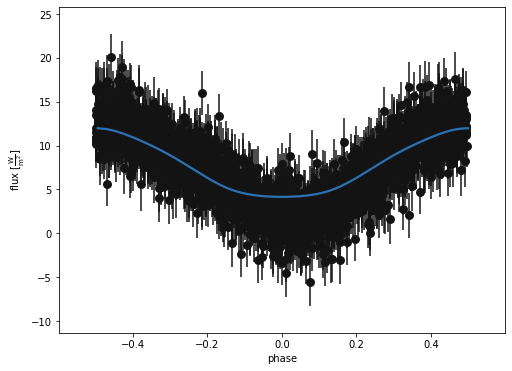

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [78]:
b.plot(x='phases',show=True)

In [79]:
b.add_compute('ellc', compute='fastcompute')
b.add_solver('optimizer.nelder_mead',
             fit_parameters=['incl@binary', 'mass@primary', 'mass@secondary', 'teff@primary'],
             compute='fastcompute')

<ParameterSet: 12 parameters | qualifiers: maxfev, xatol, fatol, compute, priors, maxiter, adaptive, priors_combine, fit_parameters, initial_values, comments, expose_lnprobabilities>

In [80]:
print(b.get_solver(kind='nelder_mead'))

ParameterSet: 11 parameters
    comments@nelder_mead01@solver: 
     compute@nelder_mead01@solver: fastcompute
   expose_lnprobabilities@neld...: False
   fit_parameters@nelder_mead0...: ['incl@binary', 'mass@primary', 'mass@secondary', 'teff@primary']
   initial_values@nelder_mead0...: {}
      priors@nelder_mead01@solver: []
     maxiter@nelder_mead01@solver: 1000000
      maxfev@nelder_mead01@solver: 1000000
    adaptive@nelder_mead01@solver: False
       xatol@nelder_mead01@solver: 0.0001
       fatol@nelder_mead01@solver: 0.0001


In [ ]:
b.run_solver(kind='nelder_mead', maxiter=100, solution='nm_sol')

In [ ]:
print(b.get_solution('nm_sol').filter(qualifier=['message', 'nfev', 'niter', 'success']))